# NSL Notebook 10

## Exercise 10.1.1

In [1]:
######                        #######
##  IMPORT DEFAULT PKGS and VARS   ##
######                        #######

from default import *

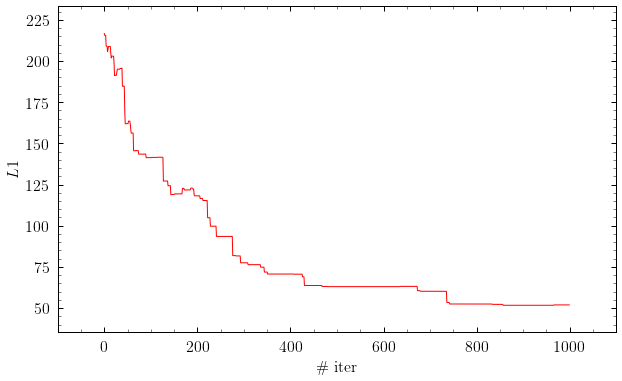

In [8]:
fig, ax = plt.subplots(figsize=(10,6))

dfb = pd.read_csv('bL1OC.out', header=None, names=['L1'])

dfb['L1'].plot.line(ls='-', c='r', ax=ax);

ax.set_ylabel('$L1$');
ax.set_xlabel('\# iter');

In [12]:
from matplotlib.animation import FuncAnimation
from time import sleep

fig, (axb, axa) = plt.subplots(1,2, figsize=(10,5));

dfb = pd.read_csv('circle.tsv', header=None, sep='\t', names=['x','y']);
dfa = pd.read_csv('OC.csv', header=None, sep=',', names=['x','y']);

xb = [dfb['x'][0]]
yb = [dfb['y'][0]]
xa = [dfa['x'][0]]
ya = [dfa['y'][0]]

def func(npt, *fargs):
    xb.append(npt[0][0])
    yb.append(npt[0][1])
    xa.append(npt[1][0])
    ya.append(npt[1][1])
    axb.plot(xb,yb, '-r');
    axa.plot(xa,ya, '-b');
    xb.pop(0)
    yb.pop(0)
    xa.pop(0)
    ya.pop(0)
    
def init_func():
    axb.scatter(dfb['x'], dfb['y'], marker='.', color='k');
    axa.scatter(dfa['x'], dfa['y'], marker='.', color='k');
    sleep(1);
    
    
frames = []
for ptb, pta in zip(np.asarray(dfb), np.asarray(dfa)):
    frames.append((ptb, pta))
    
anim = FuncAnimation(fig, func, frames, init_func, interval=300);
plt.close(fig=fig)

from IPython.display import HTML
HTML(anim.to_html5_video())

## Exercise 10.1.2

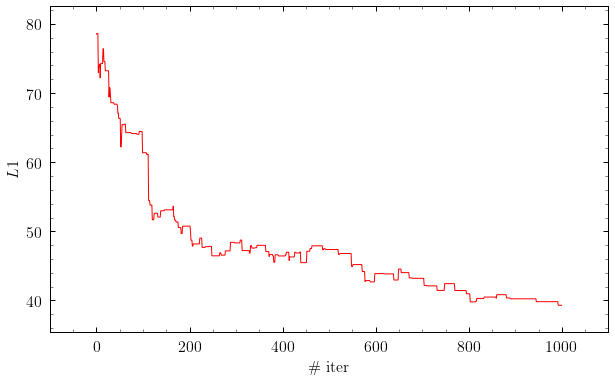

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

dfb = pd.read_csv('bL1IS.out', header=None, names=['L1'])

dfb['L1'].plot.line(ls='-', c='r', ax=ax);

ax.set_ylabel('$L1$');
ax.set_xlabel('\# iter');

In [11]:
from matplotlib.animation import FuncAnimation
from time import sleep

fig, (axb, axa) = plt.subplots(1,2, figsize=(10,5));

dfb = pd.read_csv('square.tsv', header=None, sep='\t', names=['x','y']);
dfa = pd.read_csv('IS.csv', header=None, sep=',', names=['x','y']);

xb = [dfb['x'][0]]
yb = [dfb['y'][0]]

xa = [dfa['x'][0]]
ya = [dfa['y'][0]]

def func(npt, *fargs):
    xb.append(npt[0][0])
    yb.append(npt[0][1])
    xa.append(npt[1][0])
    ya.append(npt[1][1])
    axb.plot(xb,yb, '-r');
    axa.plot(xa,ya, '-b');
    xb.pop(0)
    yb.pop(0)
    xa.pop(0)
    ya.pop(0)
    
def init_func():
    axb.scatter(dfb['x'], dfb['y'], marker='.', color='k');
    axa.scatter(dfa['x'], dfa['y'], marker='.', color='k');
    sleep(1);
    
    
frames = []
for ptb, pta in zip(np.asarray(dfb), np.asarray(dfa)):
    frames.append((ptb, pta))
    
anim = FuncAnimation(fig, func, frames, init_func, interval=300, blit=False);
plt.close(fig=fig)

from IPython.display import HTML
HTML(anim.to_html5_video())